<a href="https://colab.research.google.com/github/RubhavSaini/G_colab/blob/main/StockMarketPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance


In [20]:
!pip install plotly

In [120]:
y_train_pred = model.predict(X_train)
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

# Calculate metrics
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(y_train_rescaled, y_train_pred_rescaled))
rmse_test = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE : {rmse_test:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Train RMSE: 18.34
Test RMSE : 36.40


In [ ]:
# ----> yes overfitting is happenning
# ✅ If Train RMSE ≈ Test RMSE → good generalization

# ❌ If Train RMSE ≪ Test RMSE → clear overfitting

In [129]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping



In [171]:
from datetime import date,timedelta
today = date.today()

In [170]:
today

datetime.date(2025, 8, 2)

In [176]:
past_date = today - timedelta(days=7)
past_date=str(past_date)
past_date


'2025-07-26'

In [130]:
ticker = 'ADANIPORTS.NS'
df = yf.download(ticker, start='2015-01-01', end=past_date)
df = df[['Close']].dropna()

# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Sequence creation
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, 60)
X = X.reshape(X.shape[0], X.shape[1], 1)

/tmp/ipython-input-3507655535.py:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [141]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [142]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2 Score': round(r2, 4),
        'MAPE (%)': round(mape, 2)
    }

results = []
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [143]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
history_lstm =model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
results.append(evaluate_model("LSTM", y_test_rescaled, y_pred_lstm_rescaled))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


In [148]:
model_bilstm = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(1)
])
model_bilstm.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history_bilstm= model_bilstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_bilstm_rescaled = scaler.inverse_transform(y_pred_bilstm)
results.append(evaluate_model("Bidirectional LSTM", y_test_rescaled, y_pred_bilstm_rescaled))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


In [144]:
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
history_model_gru=model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

y_pred_gru = model_gru.predict(X_test)
y_pred_gru_rescaled = scaler.inverse_transform(y_pred_gru)
results.append(evaluate_model("GRU", y_test_rescaled, y_pred_gru_rescaled))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


In [145]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_xgb = XGBRegressor()
history_xgb=model_xgb.fit(X_train_flat, y_train)

y_pred_xgb = model_xgb.predict(X_test_flat)
y_pred_xgb_rescaled = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))
results.append(evaluate_model("XGBoost", y_test_rescaled, y_pred_xgb_rescaled))

In [146]:
model_rf = RandomForestRegressor()
history_rf=model_rf.fit(X_train_flat, y_train)

y_pred_rf = model_rf.predict(X_test_flat)
y_pred_rf_rescaled = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))
results.append(evaluate_model("Random Forest", y_test_rescaled, y_pred_rf_rescaled))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [149]:
df_results = pd.DataFrame(results).sort_values(by='RMSE').reset_index(drop=True)
df_results

,Model,MAE,RMSE,R2 Score,MAPE (%)
0,GRU,22.04,33.67,0.9889,2.18
1,Bidirectional LSTM,34.88,48.28,0.9773,3.63
2,LSTM,37.03,53.81,0.9718,3.95
3,XGBoost,246.70,335.44,-0.0977,19.18
4,Random Forest,250.47,341.98,-0.1409,19.37


In [150]:
import matplotlib.pyplot as plt

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

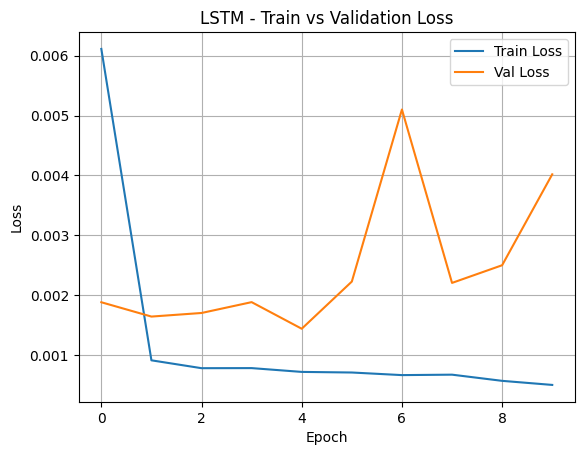

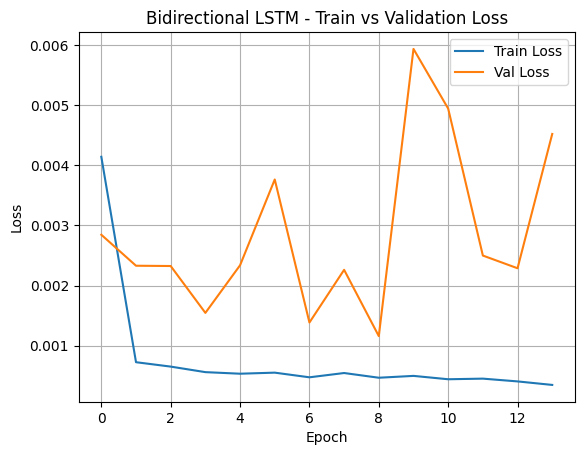

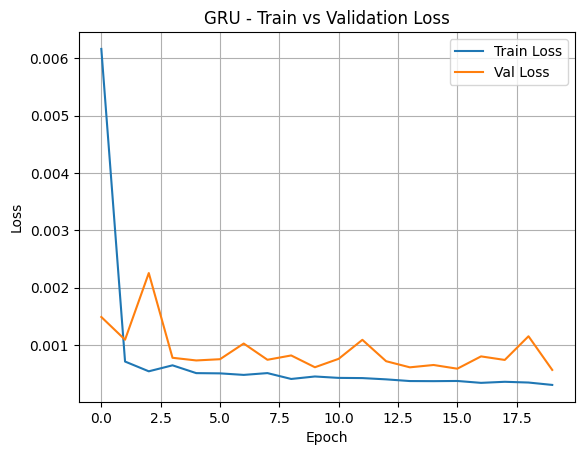

In [152]:
plot_loss(history_lstm, "LSTM - Train vs Validation Loss")
plot_loss(history_bilstm, "Bidirectional LSTM - Train vs Validation Loss")
plot_loss(history_model_gru, "GRU - Train vs Validation Loss")
# plot_loss(history_xgb, "XGBoost - Train vs Validation Loss")
# plot_loss(history_rf, "Random Forest - Train vs Validation Loss")

In [154]:
test_dates = df.index[-len(y_test_rescaled):]

fig = go.Figure()

# Actual
fig.add_trace(go.Scatter(
    x=test_dates,
    y=y_test_rescaled.flatten(),
    mode='lines',
    name='Actual Price',
    line=dict(color='black'),
    hovertemplate='Date: %{x|%d %b %Y}<br>Price: ₹%{y:.2f}<extra></extra>'
))

# LSTM
fig.add_trace(go.Scatter(
    x=test_dates,
    y=y_pred_lstm_rescaled.flatten(),
    mode='lines',
    name='LSTM Prediction',
    line=dict( color='blue')
))

# BiLSTM
fig.add_trace(go.Scatter(
    x=test_dates,
    y=y_pred_bilstm_rescaled.flatten(),
    mode='lines',
    name='BiLSTM Prediction',
    line=dict( color='green')
))

# GRU
fig.add_trace(go.Scatter(
    x=test_dates,
    y=y_pred_gru_rescaled.flatten(),
    mode='lines',
    name='GRU Prediction',
    line=dict( color='red')
))

In [164]:
n_future = 100
forecast_input = X[-1]  # last known sequence
future_preds = []

for _ in range(n_future):
    pred = model_gru.predict(forecast_input.reshape(1, X.shape[1], 1), verbose=0)[0]
    future_preds.append(pred)

    # Slide window
    forecast_input = np.append(forecast_input[1:], pred).reshape(X.shape[1], 1)

# Inverse scale
future_preds_rescaled = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

In [165]:
from datetime import timedelta

last_known_date = df.index[-1]
future_dates = [last_known_date + timedelta(days=i + 1) for i in range(n_future)]

In [166]:
fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_preds_rescaled.flatten(),
    mode='lines+markers',
    name='LSTM Forecast (Next 10 Days)',
    line=dict(color='orange', dash='dot'),
    hovertemplate='Forecast Date: %{x|%d %b %Y}<br>Price: ₹%{y:.2f}<extra></extra>'
))

In [167]:
fig.update_layout(
    title="Stock Price Prediction – Actual vs Predicted + 10-Day Forecast",
    xaxis_title='Date',
    yaxis_title='Stock Price (INR)',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0, y=1.1, orientation='h')
)

fig.show()